In [1]:
import numpy as np
import matplotlib.pyplot as plt
#%pylab qt5
%pylab inline

/Users/diana/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [3]:
# Read in RV data, remember "primary" and "secondary" definitions are switched
t, srv, serr, prv, perr = np.loadtxt('data/3955867.rv', delimiter=';', unpack=True)

#Define variables from Villanova
p = 33.6599615
t_pe = 54960.825756-54833

In [4]:
#Phase data
phase = ((t-t_pe)%p)/p

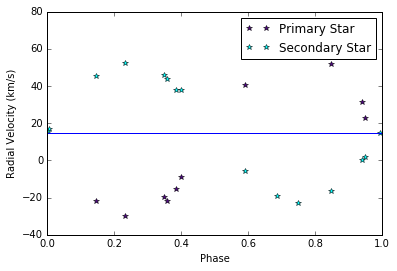

In [5]:
#Plot RVs
plt.figure()
plt.plot(phase, prv, '*', color='indigo', label='Primary Star')
plt.plot(phase, srv, '*', color='aqua', label='Secondary Star')
plt.axhline(14.7, color = 'blue')
plt.xlabel('Phase')
plt.ylabel('Radial Velocity (km/s)')
plt.legend()
plt.savefig('3955867.png')
plt.show()

In [6]:
#Finding indivudual masses
pi = np.pi
e = 0

def find_Masses(k1, k2, p, e=0):
    alpha = (2*pi*6.67e-11)/((p*3600*24)*(1-e**2)**1.5)
    x = k2/k1
    y = k1/k2
    m1 = (y/(1+x)**2) + (1/((1+y)**2))
    m1 = m1 * alpha
    m1 = (k1**3 + k2**3)/m1
    m2 = y * m1
    return m1, m2


In [11]:
run apogee_lcs.py 3955867

Isodata.cat already exists; loaded.
LC data for KIC 3955867 loaded.
Excluding  []
Clip tolerance = 1.0


In [65]:
%pylab qt
# Plot the light curve and overplot tpe to make sure Villanova value is correct. 
plt.subplot(211)
plt.plot(keblat.jd, keblat.flux, 'k-x')
plt.axvline(tpe)
plt.subplot(212)
keblat.updatephase(tpe, period)
plt.plot(keblat.phase[keblat.clip], keblat.flux[keblat.clip], 'k.')
plt.axvline(0)

Populating the interactive namespace from numpy and matplotlib


In [66]:
# Update the phase function
keblat.updatephase(tpe, period)
# Make initial guesses to lc parameters
lcpars= [M1+M2, 9.2, 6.5, period, tpe, esinw, ecosw, .01, 22, q1, q2, q3, q4]
model_fluxes, model_polynomials = keblat.lcfit(lcpars, keblat.jd[keblat.clip], 
                                               keblat.quarter[keblat.clip], keblat.flux[keblat.clip], 
                                               keblat.dflux[keblat.clip], keblat.crowd[keblat.clip], polyorder=2)
plt.plot(keblat.phase[keblat.clip], keblat.flux[keblat.clip]/model_polynomials, "k.")
plt.plot(keblat.phase[keblat.clip], model_fluxes, ".")
plt.show()
#lcmod, lcpol = keblat.lcfit(lcpars_array, keblat.jd, keblat.quarter, keblat.flux, keblat.dflux, keblat.crowd, polyorder=0)

In [32]:
keblat.parbounds['b'][1] = 0.1
keblat.parbounds['ecosw'] = [-.01, .01]
keblat.parbounds['period'] = [period*.99, period*1.01]

In [45]:
# optimize light curve using best initial parameters via trial and error
opt_lcpars0 = opt_lc(msum=M1+M2, rsum=9.2, rrat=6.5, period=period, tpe=tpe, esinw=esinw,
                             ecosw=ecosw, b=0.01, frat=22, q1=q1, q2=q2, q3=q3, q4=q4)


==================== Starting LIGHTCURVE ONLY fit... =====================
[[Fit Statistics]]
    # function evals   = 61
    # data points      = 21355
    # variables        = 7
    chi-square         = 19924342.140
    reduced chi-square = 933.312
    Akaike info crit   = 146048.279
    Bayesian info crit = 146104.063
[[Variables]]
    q1:       0.01 (fixed)
    q2:       0.01 (fixed)
    tpe:      127.832693 +/- 0.000762 (0.00%) (init= 127.8258)
    b:        0.07814271 +/- 21.25167 (27195.98%) (init= 0.01)
    ecosw:    0.00477703 +/- 0.000129 (2.71%) (init= 0.004869469)
    q4:       0.01 (fixed)
    rsum:     9.05691596 +/- 0.095956 (1.06%) (init= 9.2)
    period:   33.65996 (fixed)
    q3:       0.01 (fixed)
    msum:     1.857723 (fixed)
    frat:     26.4538698 +/- 0.069413 (0.26%) (init= 22)
    rrat:     8.93278967 +/- 0.034628 (0.39%) (init= 6.5)
    esinw:   -0.00088801 +/- 0.001951 (219.75%) (init= 0.06442577)
[[Correlations]] (unreported correlations are <  0.100)
    C

In [46]:
#Update phase function with optimized lc parameters and overplot fit
keblat.updatephase(opt_lcpars0[4], opt_lcpars0[3])
modelfluxes, modelpolynomials = keblat.lcfit(opt_lcpars0, keblat.jd[keblat.clip], keblat.quarter[keblat.clip], keblat.flux[keblat.clip], keblat.dflux[keblat.clip], keblat.crowd[keblat.clip], polyorder=2)
#plt.plot(keblat.jd, keblat.flux, "k.")
#plt.plot(keblat.jd[keblat.clip], modelfluxes*modelpolynomials, ".")
#plt.show()

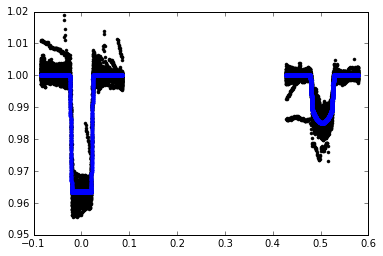

In [48]:
%matplotlib inline
plt.plot(keblat.phase[keblat.clip], keblat.flux[keblat.clip]/modelpolynomials, "k.")
plt.plot(keblat.phase[keblat.clip], modelfluxes, ".")
plt.show()

In [67]:
#save opt lc parameters
np.savetxt('data/{0}.opt_lc'.format(kic), opt_lcpars0)

In [53]:
# Load time and RV values to keblat, keblat.rvprep returns initial guesses to m1, m2, k0
m1, m2, k0 = keblat.rvprep(t, prv*1e3, srv*1e3, perr*1e3, serr*1e3)

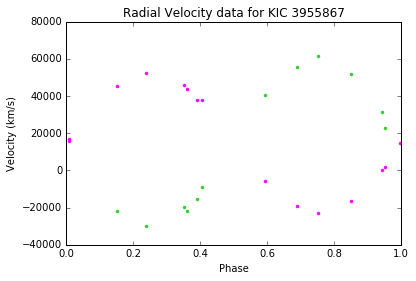

In [50]:
#Have to phase the data again becuase parameters have changed from optimization
phase2 = ((keblat.rv_t-keblat.pars['tpe'])%keblat.pars['period'])/keblat.pars['period']

plt.title('Radial Velocity data for KIC 3955867')
plt.plot(phase2, keblat.rv1_obs, '.', color='limegreen')
plt.plot(phase2, keblat.rv2_obs, '.', color='fuchsia')
plt.xlabel('Phase')
plt.ylabel('Velocity (km/s)');

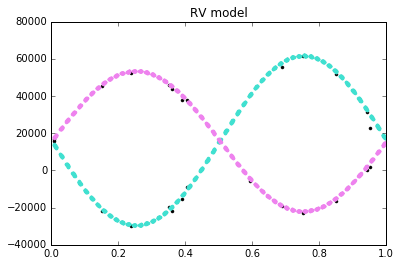

In [51]:
# Create tmod (more data points) to see model clearly
tmod = np.linspace(keblat.rv_t[0], keblat.rv_t[-1], 1000)
phasemod = ((tmod - keblat.pars['tpe'])%keblat.pars['period'])/keblat.pars['period']

# Make initial guess to rv parameters
rv1_mod, rv2_mod = keblat.rvfit([0.91+1.1, 1.1/0.91, keblat.pars['period'], keblat.pars['tpe'], 
                                 .0001, keblat.pars['ecosw'],
                                 keblat.pars['inc'], 16*1e3, 0.0], tmod)

plt.title('RV model')
plt.plot(phase2, keblat.rv1_obs, 'k.', label='Observed Data')
plt.plot(phase2, keblat.rv2_obs, 'k.')
plt.plot(phasemod, rv1_mod, '.', color='turquoise', label='Primary Star Model')
plt.plot(phasemod, rv2_mod, '.', color='violet', label='Secondary Star Model')
#plt.legend();

In [52]:
print keblat.pars['ecosw']
print opt_lcpars0

0.00510291678518
[  3.92282212e+00   1.08444570e+01   8.77639734e+00   3.36566777e+01
   1.27901504e+02   5.33752293e-03   5.10291679e-03   7.34242491e-02
   2.63444152e+01   6.85084237e-01   9.98989266e-01   1.13640161e-01
   9.51092838e-01]


In [54]:
# place tighter bounds on msum and mrat
keblat.parbounds['msum']= [0.98*(1.1+0.91), 1.02*(1.1+0.91)]
keblat.parbounds['mrat']= [0.98*(1.1/0.91), 1.02*(1.1/0.91)]
keblat.parbounds['esinw']= [-0.1,0.1]

#optimize rv pars, using initial guesses from rvprep and esinw, ecosw, inc from lc opt
opt_rvpars = opt_rv(msum=m1+m2, mrat=m2/m1, period=period, tpe=tpe, 
       esinw=opt_lcpars0[5], ecosw=opt_lcpars0[6], inc=keblat.pars['inc'], k0=16*1e3, rverr=0.0)


rverr 0.0
tpe 127.825756
ecosw 0.00510291678518
mrat 1.21039374254
period 33.6599615
msum 2.01844131121
k0 16000.0
esinw 0.0053375229276
inc 1.56961950444
========================= Starting RV ONLY fit... ========================
Parameters([('rverr', <Parameter 'rverr', value=0.0 (fixed), bounds=[0.0:10000.0]>), ('tpe', <Parameter 'tpe', value=127.82575599999836 (fixed), bounds=[0.0:100000000.0]>), ('ecosw', <Parameter 'ecosw', 0.0051029167851831241, bounds=[-0.01:0.01]>), ('mrat', <Parameter 'mrat', 1.2103937425427549, bounds=[1.1846153846153848:1.232967032967033]>), ('period', <Parameter 'period', value=33.659961500000001 (fixed), bounds=[33.323361885000004:33.996561114999999]>), ('msum', <Parameter 'msum', 2.0184413112055131, bounds=[1.9698000000000002:2.0502000000000002]>), ('k0', <Parameter 'k0', 16000.0, bounds=[-100000000.0:100000000.0]>), ('esinw', <Parameter 'esinw', 0.0053375229275969271, bounds=[-0.1:0.1]>), ('inc', <Parameter 'inc', 1.5696195044402392, bounds=[0.0:1.570796

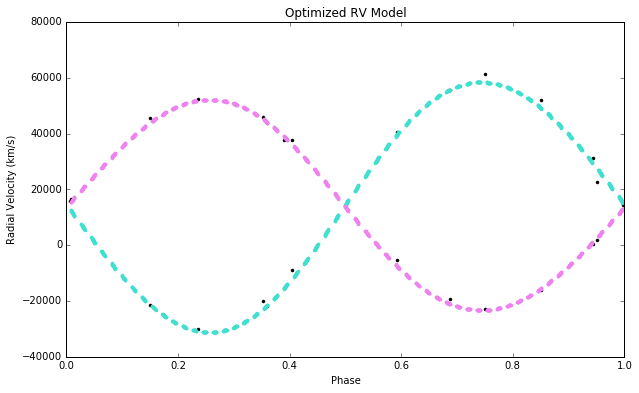

In [55]:
#overplot best fit rv model
opt_rv1_mod, opt_rv2_mod = keblat.rvfit(opt_rvpars, tmod)

plt.figure(figsize=(10,6))
plt.title('Optimized RV Model')
plt.plot(phase2, keblat.rv1_obs, 'k.', label='Observed Data')
plt.plot(phase2, keblat.rv2_obs, 'k.')
plt.plot(phasemod, opt_rv1_mod, '.', color='turquoise', label='Optimized Primary Star Model')
plt.plot(phasemod, opt_rv2_mod, '.', color='violet', label='Optimized Secondary Star Model')
#plt.legend()
plt.xlabel('Phase')
plt.ylabel('Radial Velocity (km/s)');

In [68]:
# save opt rv parameters
np.savetxt('data/{0}.opt_rv'.format(kic), opt_rvpars)

In [56]:
# re-optimize the light curve only by fixing msum to be value from opt_rv fit (see msum=opt_rvpars[0], vary_msum=False)
lcpars2 = opt_lc(msum=opt_rvpars[0], rsum=opt_lcpars0[1], rrat=opt_lcpars0[2], period=period, tpe=tpe, 
                 esinw=opt_lcpars0[5], ecosw=opt_lcpars0[6], b=opt_lcpars0[7], frat=opt_lcpars0[8], 
                 q1=q1, q2=q2, q3=q3, q4=q4, vary_msum=False)

==================== Starting LIGHTCURVE ONLY fit... =====================
[[Fit Statistics]]
    # function evals   = 61
    # data points      = 21348
    # variables        = 7
    chi-square         = 21128916.081
    reduced chi-square = 990.062
    Akaike info crit   = 147260.544
    Bayesian info crit = 147316.325
[[Variables]]
    q1:       0.01 (fixed)
    q2:       0.01 (fixed)
    tpe:      127.828233 +/- 0.000851 (0.00%) (init= 127.8258)
    b:        0.08536761 +/- 9.123075 (10686.81%) (init= 0.07342425)
    ecosw:    0.00511931 +/- 0.000126 (2.47%) (init= 0.005102917)
    q4:       0.01 (fixed)
    rsum:     8.74706593 +/- 0.090511 (1.03%) (init= 10.84446)
    period:   33.65996 (fixed)
    q3:       0.01 (fixed)
    msum:     1.980008 (fixed)
    frat:     26.5759030 +/- 0.075265 (0.28%) (init= 26.34442)
    rrat:     8.82655023 +/- 0.032298 (0.37%) (init= 8.776397)
    esinw:   -0.01298478 +/- 0.001859 (14.32%) (init= 0.005337523)
[[Correlations]] (unreported correlatio

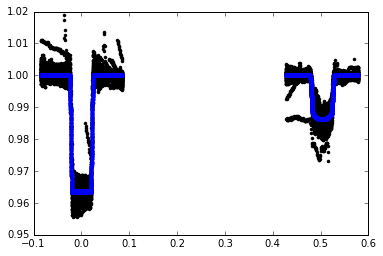

In [57]:
#overplot the new light curve model to make sure it's still decent
model_fluxes2, model_polynomials2 = keblat.lcfit(lcpars2, keblat.jd[keblat.clip], 
                                                 keblat.quarter[keblat.clip], keblat.flux[keblat.clip], 
                                                 keblat.dflux[keblat.clip], keblat.crowd[keblat.clip], polyorder=2)
plt.plot(keblat.phase[keblat.clip], keblat.flux[keblat.clip]/model_polynomials2, 'k.')
plt.plot(keblat.phase[keblat.clip], model_fluxes2, '.')

In [58]:
#do a simultaneous lcrv opt with rvpars from opt_rv and lcpars from result above ^
opt_lcrvpars=opt_lcrv(msum=opt_rvpars[0], mrat=opt_rvpars[1], rsum=lcpars2[1], rrat=lcpars2[2], period=lcpars2[3], 
                      tpe=lcpars2[4], esinw=lcpars2[5],ecosw=lcpars2[6],b=lcpars2[7], frat=lcpars2[8], 
                      q1=lcpars2[9], q2=lcpars2[10], q3=lcpars2[11], q4=lcpars2[12], lcerr=0, k0=opt_rvpars[-2], rverr=0)

================= Starting LC + RV simultaneous fit... ===================
243.106937361 238.04467492
[[Fit Statistics]]
    # function evals   = 39
    # data points      = 21375
    # variables        = 17
    chi-square         = 5084158.167
    reduced chi-square = 238.045
    Akaike info crit   = 116990.791
    Bayesian info crit = 117126.280
[[Variables]]
    q1:       0.69960712 +/- 0        (0.00%) (init= 0.8423917)
    q2:       0.46461519 +/- 0        (0.00%) (init= 0.4253352)
    tpe:      127.904206 +/- 0        (0.00%) (init= 127.907)
    b:        0.09279094 +/- 0        (0.00%) (init= 0.01767344)
    ecosw:    0.00526087 +/- 0        (0.00%) (init= 0.005225005)
    q4:       0.33378667 +/- 0        (0.00%) (init= 0.4536042)
    rsum:     8.49719953 +/- 0        (0.00%) (init= 8.59576)
    mrat:     1.22910780 +/- 0        (0.00%) (init= 1.186061)
    period:   33.6566108 +/- 0        (0.00%) (init= 33.65651)
    q3:       0.12356798 +/- 0        (0.00%) (init= 0.0774701)

In [69]:
#overplot best fit parameters to see rv + lc model against data
make_lcrv_plots(kic, opt_lcrvpars, '', suffix='', savefig=False, polyorder=2)
#save opt lcrv
np.savetxt('data/{0}.opt_lcrv'.format(kic), opt_lcrvpars)

In [60]:
keblat.pars

OrderedDict([('m1', 0.90088755424727252),
             ('m2', 1.1072879207044526),
             ('z0', None),
             ('age', None),
             ('dist', None),
             ('ebv', None),
             ('h0', None),
             ('period', 33.656610829470559),
             ('tpe', 127.90420615416132),
             ('esinw', 0.0066047521056346453),
             ('ecosw', 0.0052608737714274992),
             ('b', 0.092790945531639316),
             ('q1', 0.69960712517081902),
             ('q2', 0.46461519352898617),
             ('q3', 0.12356798360634347),
             ('q4', 0.3337866771359006),
             ('lcerr', 0.0),
             ('isoerr', None),
             ('k0', 13821.009983778),
             ('rverr', 0.0),
             ('msum', 2.0081754749517251),
             ('mrat', 1.229107800950404),
             ('rsum', 8.4971995316594384),
             ('rrat', 8.6474441700152287),
             ('r1', 0.88077208656663575),
             ('r2', 7.6164274450928033),
       

You'll notice that our esinw and ecosw values differ slightly from Patrick's published values. *But*, if you look closely at the lc fit, the steepness of ingress/egress is not well matched in the shallower eclipse. The RV residuals look similar (again, remember that his RV is phased different b/c of primary + secondary definitions). So... this kind of gives me confidence that our esinw, ecosw values are actually better? 